In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import sqrt
from qutip import *
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema, find_peaks, argrelmin
from qutip.ipynbtools import plot_animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.animation as animation
from IPython.display import HTML

The single qubit simulation will use system constants from Schuster's thesis: Circuit Quantum Electrodynamics. The Qutip notebook the code is derived from can be found at: https://nbviewer.ipython.org/github/qutip/qutip-notebooks/blob/master/examples/rabi-oscillations.ipynb.
\\
This simulation makes use of the Jaynes-Cummings Hamiltonian: \\
$$\hat{H}/\hbar = \omega_c\hat{a}^{†}a + \frac{1}{2}\omega_q\hat{\sigma}_z + \frac{1}{2}g(\hat{a}\hat{\sigma}_+ + \hat{a}^{†}\hat{\sigma}_-)$$

### Setting the system constants
All constant in units of GHz, the set values are from Schuster. Time is in units of nanoseconds.


In [27]:
# Cavity frequency
wc = 5.5 * 2 * np.pi
#detuning 
delta = 0
#qubit frequency
wq = wc + delta*2*np.pi
#coupling
g = 0.017 * 2 * np.pi
# number of energy levels in the cavity
N = 20
# use rotating wave approx. or not
use_rwa = True
# cavity dissapation rate
kappa = 0.005 * 2 * np.pi 
# qubit dissapation rate
gamma = 0.002 * 2 * np.pi * kappa


#the list of times to evolve the system over
tlist = np.linspace(0, 50, 1001)

### Calculate the Theoretical Rabi Frequency
We can calculate the Rabi frequency for the Jaynes-Cummings model to compare the simulation value to later


In [28]:
rabi_f = sqrt(4*(g**2) + (wq-wc)**2)
print(rabi_f)

0.21362830044410594


### Operators and Hamiltonian
The destroy() and qeye() matrices are default Fock basis, with the specified size. 

In [29]:
# annhiliation and spin operator
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))


#number of photons in cavity, and in qubit (operators)
nc = a.dag() * a
nq = sm.dag() * sm # where sz = sm.dag * sm

#Hamiltonian: Jaynes-Cumming
if use_rwa:
    H = wc * nc + wq * nq + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * nc + wq * nq + g * (a.dag() + a) * (sm + sm.dag())

### Time Evolution of the System
First we place quanta in the qubit excited state, with the cavity remaining in ground state. We define the collapse operators to add noise to our system. 

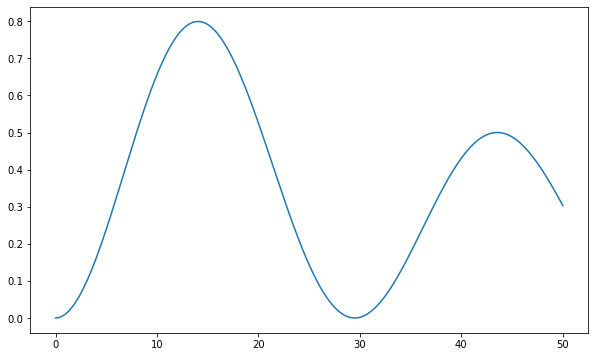

In [35]:
# initial state of the system
psi0 = tensor(basis(N,0), basis(2,1))
collapse_ops = [sqrt(kappa)*a, sqrt(gamma) * sm]

output = mesolve(H, psi0, tlist, collapse_ops, [])
# get the expectation of the number of cavity photons
# n_c must be seperate since we still need the density matrices
n_c = np.array([expect(nc, output.states[t]) for t in range(len(tlist))])
fig, axes = plt.subplots(1, 1, figsize=(10,6))
axes.plot(tlist, n_c, label="Cavity")

Get the necessary times where the cavity is unoccupied, as well as the 
density matrices

In [48]:
# the delta = 0.0001 is picked on a case-by-case basis to get a reasonable
# number of plots. We need >2 to make judgements about the wigner function
output_gs_times = np.where(n_c <= 0.0001)[0]
dmL = np.array(output.states)[output_gs_times]

### Graph the Wigner Function Over Time

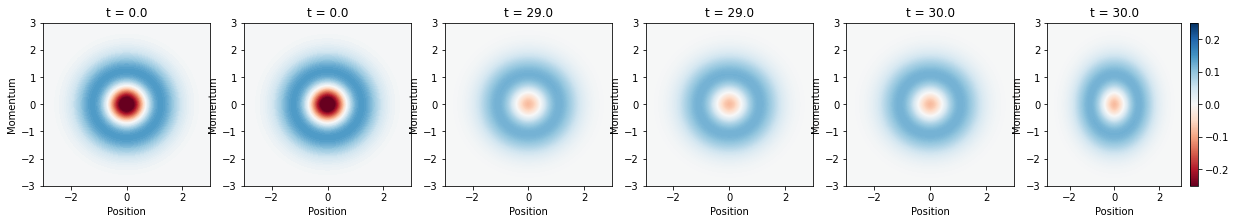

In [49]:
# set the x and y axes, in our case xvec is alpha = x + ip 
xvec = np.linspace(-3,3,200)

# make the graph + color map for the probability
fig, axes = plt.subplots(1,len(dmL), sharex=True, figsize=(3*len(dmL)+3,3))
cm = plt.get_cmap('RdBu')
sm = plt.cm.ScalarMappable(cmap=cm, norm=mpl.colors.Normalize(-.25,.25))
plt.colorbar(sm)


tlist = np.around(tlist, 0)
for idx, dm in enumerate(dmL):
    # get reduced dm for cavity
    dm_cavity = ptrace(Qobj(dm), 0)
    
    # calculate its wigner function
    W = wigner(dm_cavity, xvec, xvec) # yes this is position and momentum - wigner_transform is more specific
    
    # plot its wigner function
    axes[idx].contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-.25,.25), cmap=cm)
    axes[idx].set_xlabel("Position") # I think this is right ... not sure, here are the sources
    axes[idx].set_ylabel("Momentum")
    axes[idx].set_title(f"t = {tlist[output_gs_times][idx]}")

### Make the 3D animation of the wigner function
Use the FuncAnimation from matplotlib animation to animate ... most of this can be found in exampe code

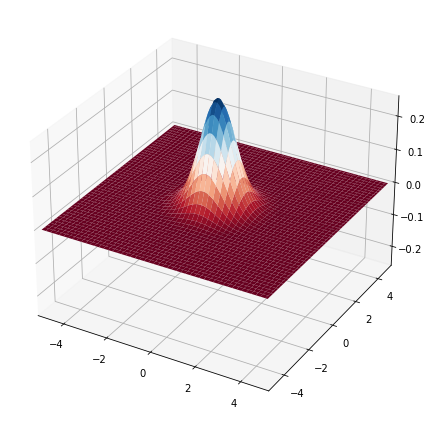

In [51]:
plt.rcParams["figure.figsize"] = [12,6]
plt.rcParams["figure.autolayout"] = True

fps = 20
frn = 75

# redefine xvec scale so it's easier to see
xvec = np.linspace(-5.,5.,100)
x,y = np.meshgrid(xvec, xvec)

#the initial picture in the animation - trace out qubit so only cavity state remains
dm_cavity = ptrace(Qobj(output.states[0]), 0)
W = wigner(dm_cavity, xvec, xvec)    

# FuncAnimation takes in a "state change" function
def update_plot(frame_number):
    """
    returns: evolved 3D plot as step in animation
    params: frame_number - which frame the animation is on
    """
    # reset the plot
    plot[0].remove()
    # get cavity only dm
    dm_cavity = ptrace(output.states[frame_number], 0)
    W = wigner(dm_cavity, xvec, xvec)
    # reset plot 
    plot[0] = ax.plot_surface(x,y,W, cmap = plt.get_cmap('RdBu'))
    return plot
    
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
plot = [ax.plot_surface(x, y, W, color='0.75',rstride=1, cstride=1)]


ax.set_xlim3d(-5, 5)
ax.set_ylim3d(-5, 5)
ax.set_zlim3d(-0.25, 0.25)

anim = animation.FuncAnimation(fig, update_plot, frn, interval=1000/fps, blit = False)
HTML(anim.to_html5_video())